This notebook details the sets of scripts that were used to generate random files. The summation of the results are shown in random_results_file.

## Notebook imports

In [1]:
from __future__ import division
import os
import numpy as np
import random 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline
import itertools

import imp
twto = imp.load_source('twto','scripts/twang_toolbox.py')
meth = imp.load_source('meth','scripts/methy_parsing.py')

from sklearn import cross_validation, linear_model, metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats as smstats
import scipy.stats as stats
import scipy.cluster.hierarchy as hac

In [2]:
sns.set(context='notebook',style='ticks')

In [3]:
def apply_model(mod_obj,df):
    predictions = mod_obj.predict(df)
    return pd.Series([2**x for x in predictions],index=df.index,name='EpiAgeMonths')/30.42
def make_lmreg(x,y):
    lm = linear_model.LinearRegression()
    lm = lm.fit(pd.DataFrame(x),y)
    return lm.coef_[0],lm.intercept_
def extract_data(cat,predictions_dict,filein=False):
    if not filein:
        predictions_df = predictions_dict[cat]
    else:
        predictions_df = predictions_dict
    map_treatment = {'D':'D', 'Rapa':'Rapa', 'CR':'CR', 'normal':'control', 'high/high':'control', 'high/low':'control', 'low/high':'control'}
    predictions_df['treatment2'] = predictions_df['treatment'].map(map_treatment)
    predictions_df['Epi-actual'] = predictions_df['EpiAgeMonths'] -predictions_df['Age_month']
    map_control_treatment_strains = {'Ames':{2:{'D':'2m dwarf','control':'2m Ames control'},22:{'D':'22m dwarf','control':'22m Ames control'}},
                                 'Miller':{2:{'control':'2m UMHET3'},22:{'control':'22m UMHET3','Rapa':'Rapa','CR':'CR'}},'SRP032932':{'control':'C57BL6'}}
    for k,grp in predictions_df.groupby('Study'):
        if k !='SRP032932':
            for k2,grp2 in grp.groupby('Age_month'):
                study_map_mouse = map_control_treatment_strains[k][k2]
                predictions_df.loc[grp2.index,'mouse'] = predictions_df.loc[grp2.index,'treatment2'].map(study_map_mouse)
        else:
            study_map_mouse = map_control_treatment_strains[k]
            predictions_df.loc[grp.index,'mouse'] = predictions_df.loc[grp.index,'treatment2'].map(study_map_mouse)
    controls = predictions_df[predictions_df['treatment2']=='control']
    mean_resid = {}
    for k,grp in controls.groupby(['Age_month','Study']):
        mean_resid[k] = grp['Epi-actual'].mean()
    mean_resid_rows = [mean_resid[k] for k in mean_resid]
    mean_resid_columns = [k for k in mean_resid]
    df_row = pd.DataFrame(mean_resid_rows,index=mean_resid_columns,columns=[cat]).T
    return(df_row)
def shuffle2(df, n):
   ind = df.index
   for i in range(n):
       sampler = np.random.permutation(df.shape[0])
       new_vals = df.take(sampler).values
       df = pd.DataFrame(new_vals, index=ind,columns=df.columns)
   return df

## Outline

To generate random data, the covariates were shuffled within each study and written as an hdf file. The methylation values remain unshuffled. This randomization is to assess whether ComBat normalization, according to their covariates, alone dictate the performance of the predictor. The resulting randomized covariates are then normalized using ComBat, nonparametric, and the normalized data is then used to train random models of epigenetic age. The prediction error, or residual of epigenetic age - chronological age, according to their shuffled labels allows us to study if the label itself dictates the prediction performance due to ComBat.

#### Generating random data

In [4]:
#Read in all data
uncorrected_all_data_file = 'data/AllData_non_normalized_data_logage.h5'
uncorrected_data = pd.read_hdf(uncorrected_all_data_file,'methy_mat')
covariates_combined = pd.read_hdf(uncorrected_all_data_file,'covariates')

This is an example of how the data are shuffled the actual shuffled dataframes are not provided

In [ ]:
#j=0
#while j<=150:
#    shuffled_cat = 'Shuffled_permutation_{}'.format(j)
#    shuffled_covs = []
#    index_list = []
#    for k,grp in covariates_combined.groupby('Study'):
#        shuffled_grp = shuffle2(grp,2)
#        shuffled_covs = shuffled_covs+shuffled_grp.values.tolist()
#        index_list = index_list+shuffled_grp.index.values.tolist()
#    shuffled_covs = pd.DataFrame(shuffled_covs,index=index_list)
#    shuffled_covs.columns = ['Study','age_days','gender','treatment','age_groupings']
#    shuffled_data_f = os.path.join(shuffled_data_d_alldata,'{}.h5'.format(shuffled_cat))
#    df_dict = {'methy_mat':all_data_uc.loc[shuffled_covs.index],'covariates':shuffled_covs}
#    twto.save_hdf_file(df_dict,shuffled_data_f)
#    j=j+1

Shuffled data is then combat normalized using an ipython script that is found in 'scripts/combat_nonparametric_shuffling_inputShuffled.ipy'. This script takes as input the hdffile that is already shuffled using the above script, where the methylation values are labeled under 'methy_mat' and the covariates are labeled with 'covariates' in the hdffile, a single column file describing the index to use as training and a single column describing the index to reserve as test, the prefix to label the shuffled dataframes. The iteration of shuffling is given by the filename of the input with a '_number' type of format so the number is retained in the shuffled normalized dataframe. These scripts were executed with access to a parallel computing cluster.

After normalizing and saving the dataframes, the following executes the selection of regularization parameters, described in MouseEpigeneticAgingModel ipython notebook. Then the selection of the most optimal parameters are shown in the example scripts below. 

Shuffled data d is the directory with the shuffled Combat Normalized hdf files, test files are denoted with the prefix 'AdamsData_' <br>
This is just an example

In [ ]:
random_hdf_dict = {}
random_hdf_dict_test = {}
flist = twto.make_files_tuple(shuffled_data_d,'.h5')
for fname,fpath in flist:
    cat = fname.split('.h5')[0]
    if cat.startswith('Adams'):
        cat = cat.split('AdamsData_')[1]
        random_hdf_dict_test[cat] = fpath
    else:
        random_hdf_dict[cat]=fpath

This is an example of the configuration file being used in parallel computing environment. <br>
To reduce the number of individual jobs, the jobs are concatenated and split into batches <br>
To make it evenly divisible by the number of jobs, we only considered the first 110.

In [ ]:
cfig_file_list = []
overall_count = 0
file_comb_count = 0
y = 0
cfig_file = os.path.join(shuffled_cfig_d,'Dummy.txt')
while y in range(110): 
    cfig_lines_combined = []
    while overall_count < 10:
        key_rand = random_hdf_dict.keys()[:110][y]
        markerfile = 'all'
        hdffile = random_hdf_dict[key_rand]
        outd_enet = os.path.join(shuffled_enet_d,key_rand)
        twto.make_directory(outd_enet)
        nfolds = 4
        cfig_lines_iter = meth.make_cross_validation_config_forloop(outd_enet,errord,hdffile,cfig_file,alph_rat_file_list,variable_name='age_days',markers2use='all',other_arguments=[True,nfolds,'age_groupings'],return_lines=True)
        cfig_lines_combined = cfig_lines_combined+cfig_lines_iter
        overall_count = overall_count+1
        file_comb_count = file_comb_count+1
        y = y+1
    cfig_file = os.path.join(shuffled_cfig_d,'1601124_{}_{}_CrossVal.txt'.format(file_comb_count-10,file_comb_count))
    twto.write_space_delimited_file(cfig_lines_combined,cfig_file)
    cfig_file_list.append(cfig_file)
    overall_count = 0
for cfig_file in cfig_file_list:
    error_dir_name = '_'.join(cfig_file.split('/')[-1].split('_')[1:3])
    i = cfig_file.split('/')[-1].split('_')[2]
    errord = os.path.join(shuffled_error_d,error_dir_name,'errorlogging')
    twto.make_directory(errord)
    py_script = 'scripts/CV_ElasticNet_Training_stratifiedKfold_stratname_general_loopRegParams.py'
    twto.submit_qsub_argument(cfig_file,errord,25,'CVRandComb{}'.format(i),8,py_script,long=False,testing=False)     

The following scripts parses the results and determines the optimal parameters for regularization, and fits and makes predictions with the most optimal parameters.

In [ ]:
pc_play_dict_rand = {}
for cat in random_hdf_dict.keys()[:120]:
    if cat not in pc_play_dict_rand:
        outd_enet = os.path.join(shuffled_enet_d,cat)
        cv_results = meth.aggregate_cross_validation_results(outd_enet)
        cv_results['round_mp'] = cv_results['mean_p'].round(2)
        pc_play_dict_rand[cat] = cv_results

In [ ]:
optimal_parameter_dict_rand = {}
for cat in pc_play_dict_rand:
    if cat not in optimal_parameter_dict_rand:
        alph = pc_play_dict_rand[cat].sort_values(by=['mean_rmse','round_mp'],ascending=[True,False]).iloc[0]['alpha']
        lirat = pc_play_dict_rand[cat].sort_values(by=['mean_rmse','round_mp'],ascending=[True,False]).iloc[0]['lirat']
        optimal_parameter_dict_rand[cat] = (alph,lirat)

In [ ]:
#Model fitting and making predictions for the test.
prediction_results_rand = {}
for cat in optimal_parameter_dict_rand:
    if cat not in prediction_results_rand:
        hdffile = random_hdf_dict[cat]
        hdffile_test = random_hdf_dict_test[cat]
        df2use = pd.read_hdf(hdffile,'methy_mat')
        covs2use =  pd.read_hdf(hdffile,'covariates')
        testdf2use = pd.read_hdf(hdffile_test,'methy_mat')
        test_covs = pd.read_hdf(hdffile_test,'covariates')
        alph = optimal_parameter_dict_rand[cat][0]
        lirat = optimal_parameter_dict_rand[cat][1]
        enet = linear_model.ElasticNet(alpha=alph,l1_ratio=lirat,max_iter=10000)
        mod_iter = enet.fit(df2use,covs2use['age_days'])
        interventions_age = apply_model(mod_iter,testdf2use)
        adams_df = test_covs.loc[testdf2use.index].join(interventions_age)
        adams_df['Age_month'] = (2**adams_df['age_days']/30.42).round(1)
        prediction_results_rand[cat] = adams_df

In [ ]:
#Extracts the relevant residual error example
randoms = []
for cat in prediction_results_rand:
    df_row = extract_data(cat,cv_results_dict_rand,prediction_results_rand)
    randoms.append(df_row)
random_data = pd.concat(randoms)

The results of this creates a randoms data shown in random_data_file.

In [5]:
random_data_file = 'data/epigenetic_aging_model/RandomResults.txt'
random_data = pd.read_csv(random_data_file,sep='\t',header=0,index_col=0)

In [6]:
random_data.columns

Index([u'(2.1000000000000001, 'SRP032932')', u'(22.0, 'Miller')',
       u'(22.0, 'Ames')', u'(2.0, 'Miller')', u'(2.0, 'Ames')'],
      dtype='object')

In [7]:
map_columns2tups = {"(22.0, 'Ames')":(22.0, u'Ames'), "(2.0, 'Miller')":(2.0, 'Miller'),
       "(2.1000000000000001, 'SRP032932')":(2.1, u'SRP032932'), "(22.0, 'Miller')":(22.0, 'Miller'),
      "(2.0, 'Ames')":(2.0, 'Ames')}
random_data.columns = pd.Series(random_data.columns).map(map_columns2tups)

In [8]:
actual_data_file = 'data/epigenetic_aging_model/RealResults.txt'
actual_data = pd.read_csv(actual_data_file,sep='\t',header=0,index_col=0)
actual_data_summary = extract_data('',actual_data,filein=True)

In [9]:
actual_data_summary.columns

Index([(2.1, u'SRP032932'),   (22.0, u'Miller'),     (22.0, u'Ames'),
          (2.0, u'Miller'),      (2.0, u'Ames')],
      dtype='object')

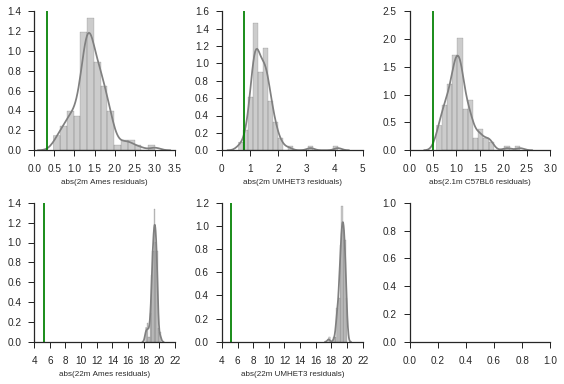

In [10]:
cols2plot = actual_data_summary.columns
f,axes = plt.subplots(2,3)
ind = 0
m = 0
cols2plot_map = {(22.0, u'Ames'):'22m Ames residuals',(22.0, u'Miller'):'22m UMHET3 residuals',(2.0, u'Miller'):'2m UMHET3 residuals', actual_data_summary.columns[0]:'2.1m C57BL6 residuals',(2.0, u'Ames'):'2m Ames residuals'}
                 #'b_controls':'intercept untreated', 'b_notcontrols':'intercept treated', 'm_controls':'slope untreated'}
for n,col in enumerate(sorted(cols2plot_map.keys())):
    if ind == 3:
        ind =0
        m=1
    ax = axes[m][ind]
    xlab = cols2plot_map[col]
    ax = sns.distplot(random_data[col].abs(),label='random',ax=ax,color='gray')
    ax.axvline(abs(actual_data_summary[col].values[0]),label='actual',color='green')
    #if len(col)!=2:
    ax.set_xlabel('abs({})'.format(xlab),fontsize=8)
    #else:
    #    ax.set_xlabel('{},{}'.format(round(col[0],2),col[1]))
    #ax.legend()
    ind = ind+1
f.tight_layout()
sns.despine()
plt.show()
plt.close()